In [3]:
import matplotlib.pyplot as plt


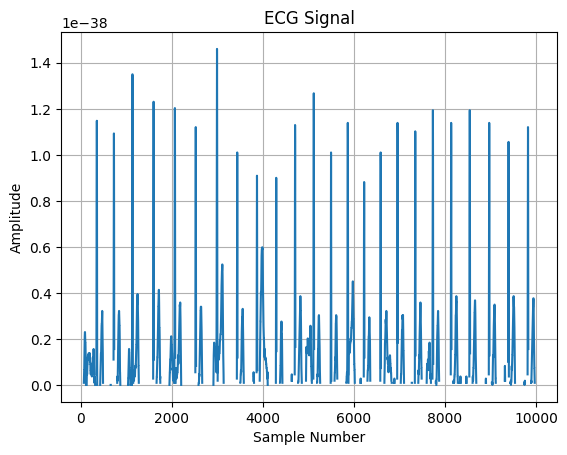

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Read the data from the file
ecg_data = np.fromfile('rec_1.dat', dtype=np.float32)

# Plot the ECG data
plt.plot(ecg_data)
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.title('ECG Signal')
plt.grid(True)
plt.show()

[-17 -16 -14 ... -13 -16 -16]


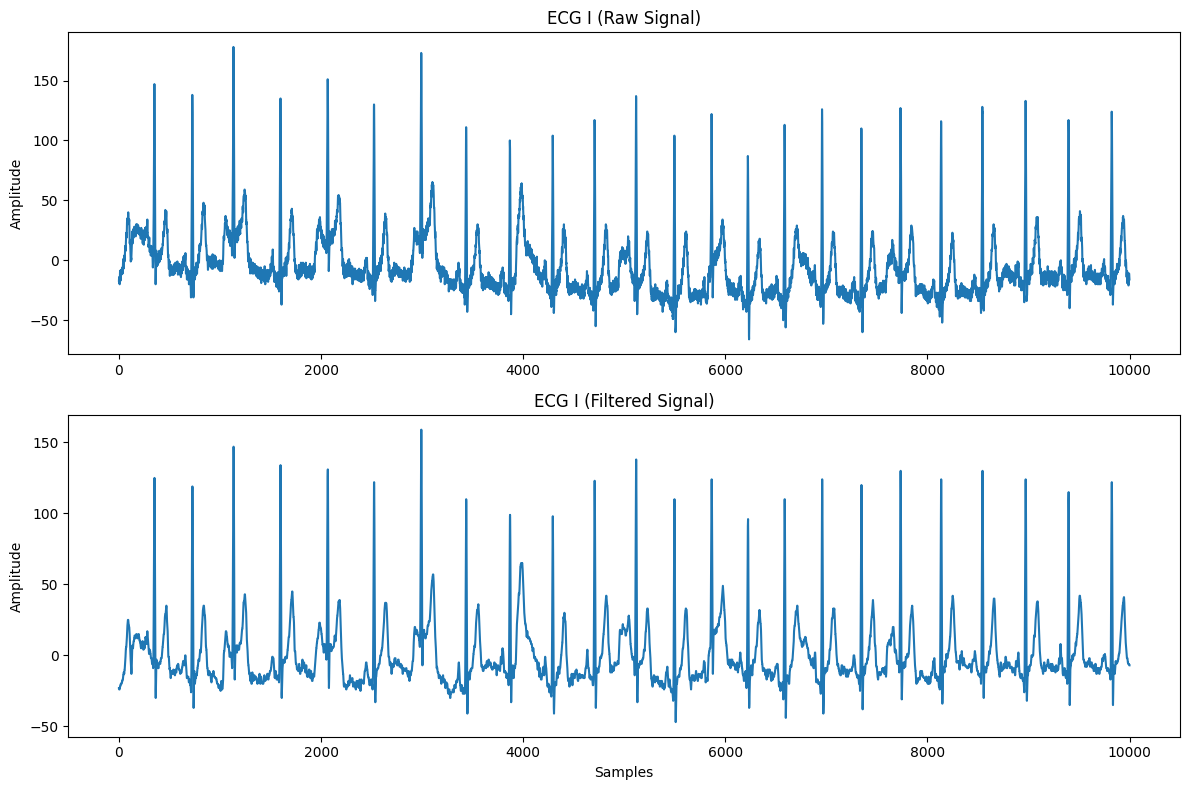

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Load the signals
def load_signals(filename):
    # Since the data is stored as 16-bit integers
    data = np.fromfile(filename, dtype=np.int16)

    # Split the data into the two signals (raw and filtered)
    # Assuming interleave format
    raw_signal = data[::2]
    filtered_signal = data[1::2]

    return raw_signal, filtered_signal

raw_signal, filtered_signal = load_signals('rec_1.dat')

print(raw_signal)
# Plot the signals
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(raw_signal)
plt.title('ECG I (Raw Signal)')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(filtered_signal)
plt.title('ECG I (Filtered Signal)')
plt.xlabel('Samples')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

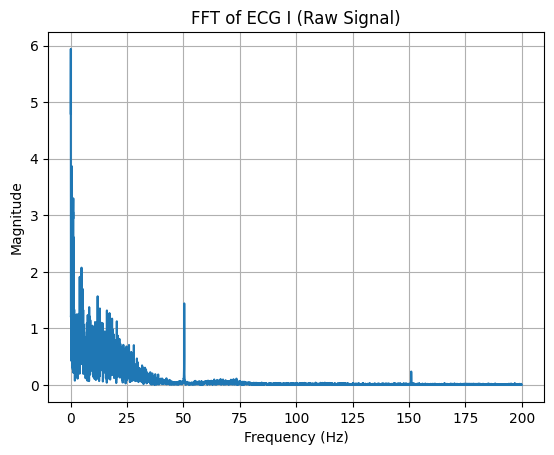

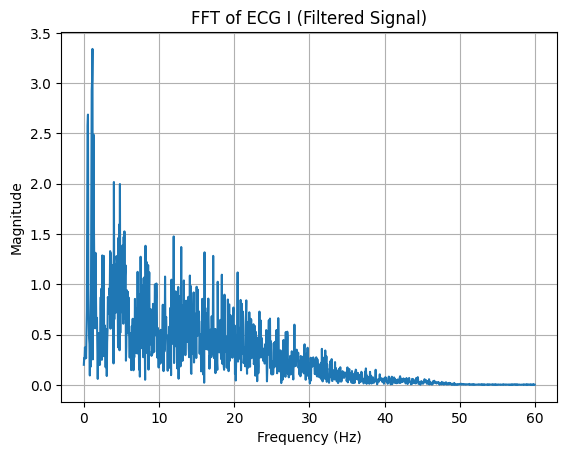

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Load the signals
def load_signals(filename):
    data = np.fromfile(filename, dtype=np.int16)
    raw_signal = data[::2]
    filtered_signal = data[1::2]
    return raw_signal, filtered_signal
def plot_fft(signal, sampling_rate, limit):
    # Compute the FFT
    N = len(signal)
    fft_vals = np.fft.fft(signal)
    # Convert to magnitude and normalize
    magnitude = np.abs(fft_vals) / N
    # Create frequency bins
    freqs = np.fft.fftfreq(N, 1 / sampling_rate)
    
    # Find the index corresponding to 100Hz
    idx = np.where(freqs >= limit)[0][0]
    
    # Plot up to 100Hz only for positive frequencies
    plt.plot(freqs[:idx], magnitude[:idx])
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title('FFT')
    plt.grid(True)

raw_signal, filtered_signal = load_signals('rec_1.dat')



plot_fft(raw_signal, 500 , 200)
plt.title('FFT of ECG I (Raw Signal)')
plt.show()


plot_fft(filtered_signal, 500 ,60)
plt.title('FFT of ECG I (Filtered Signal)')


plt.show()

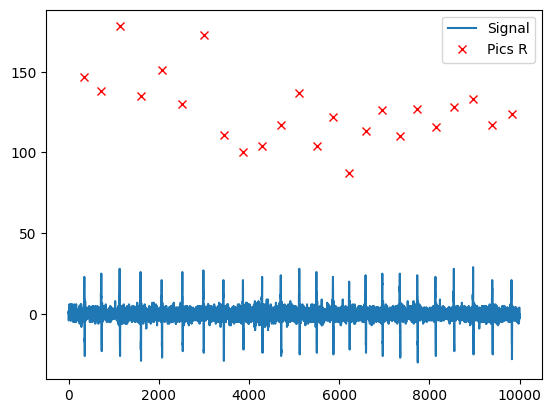

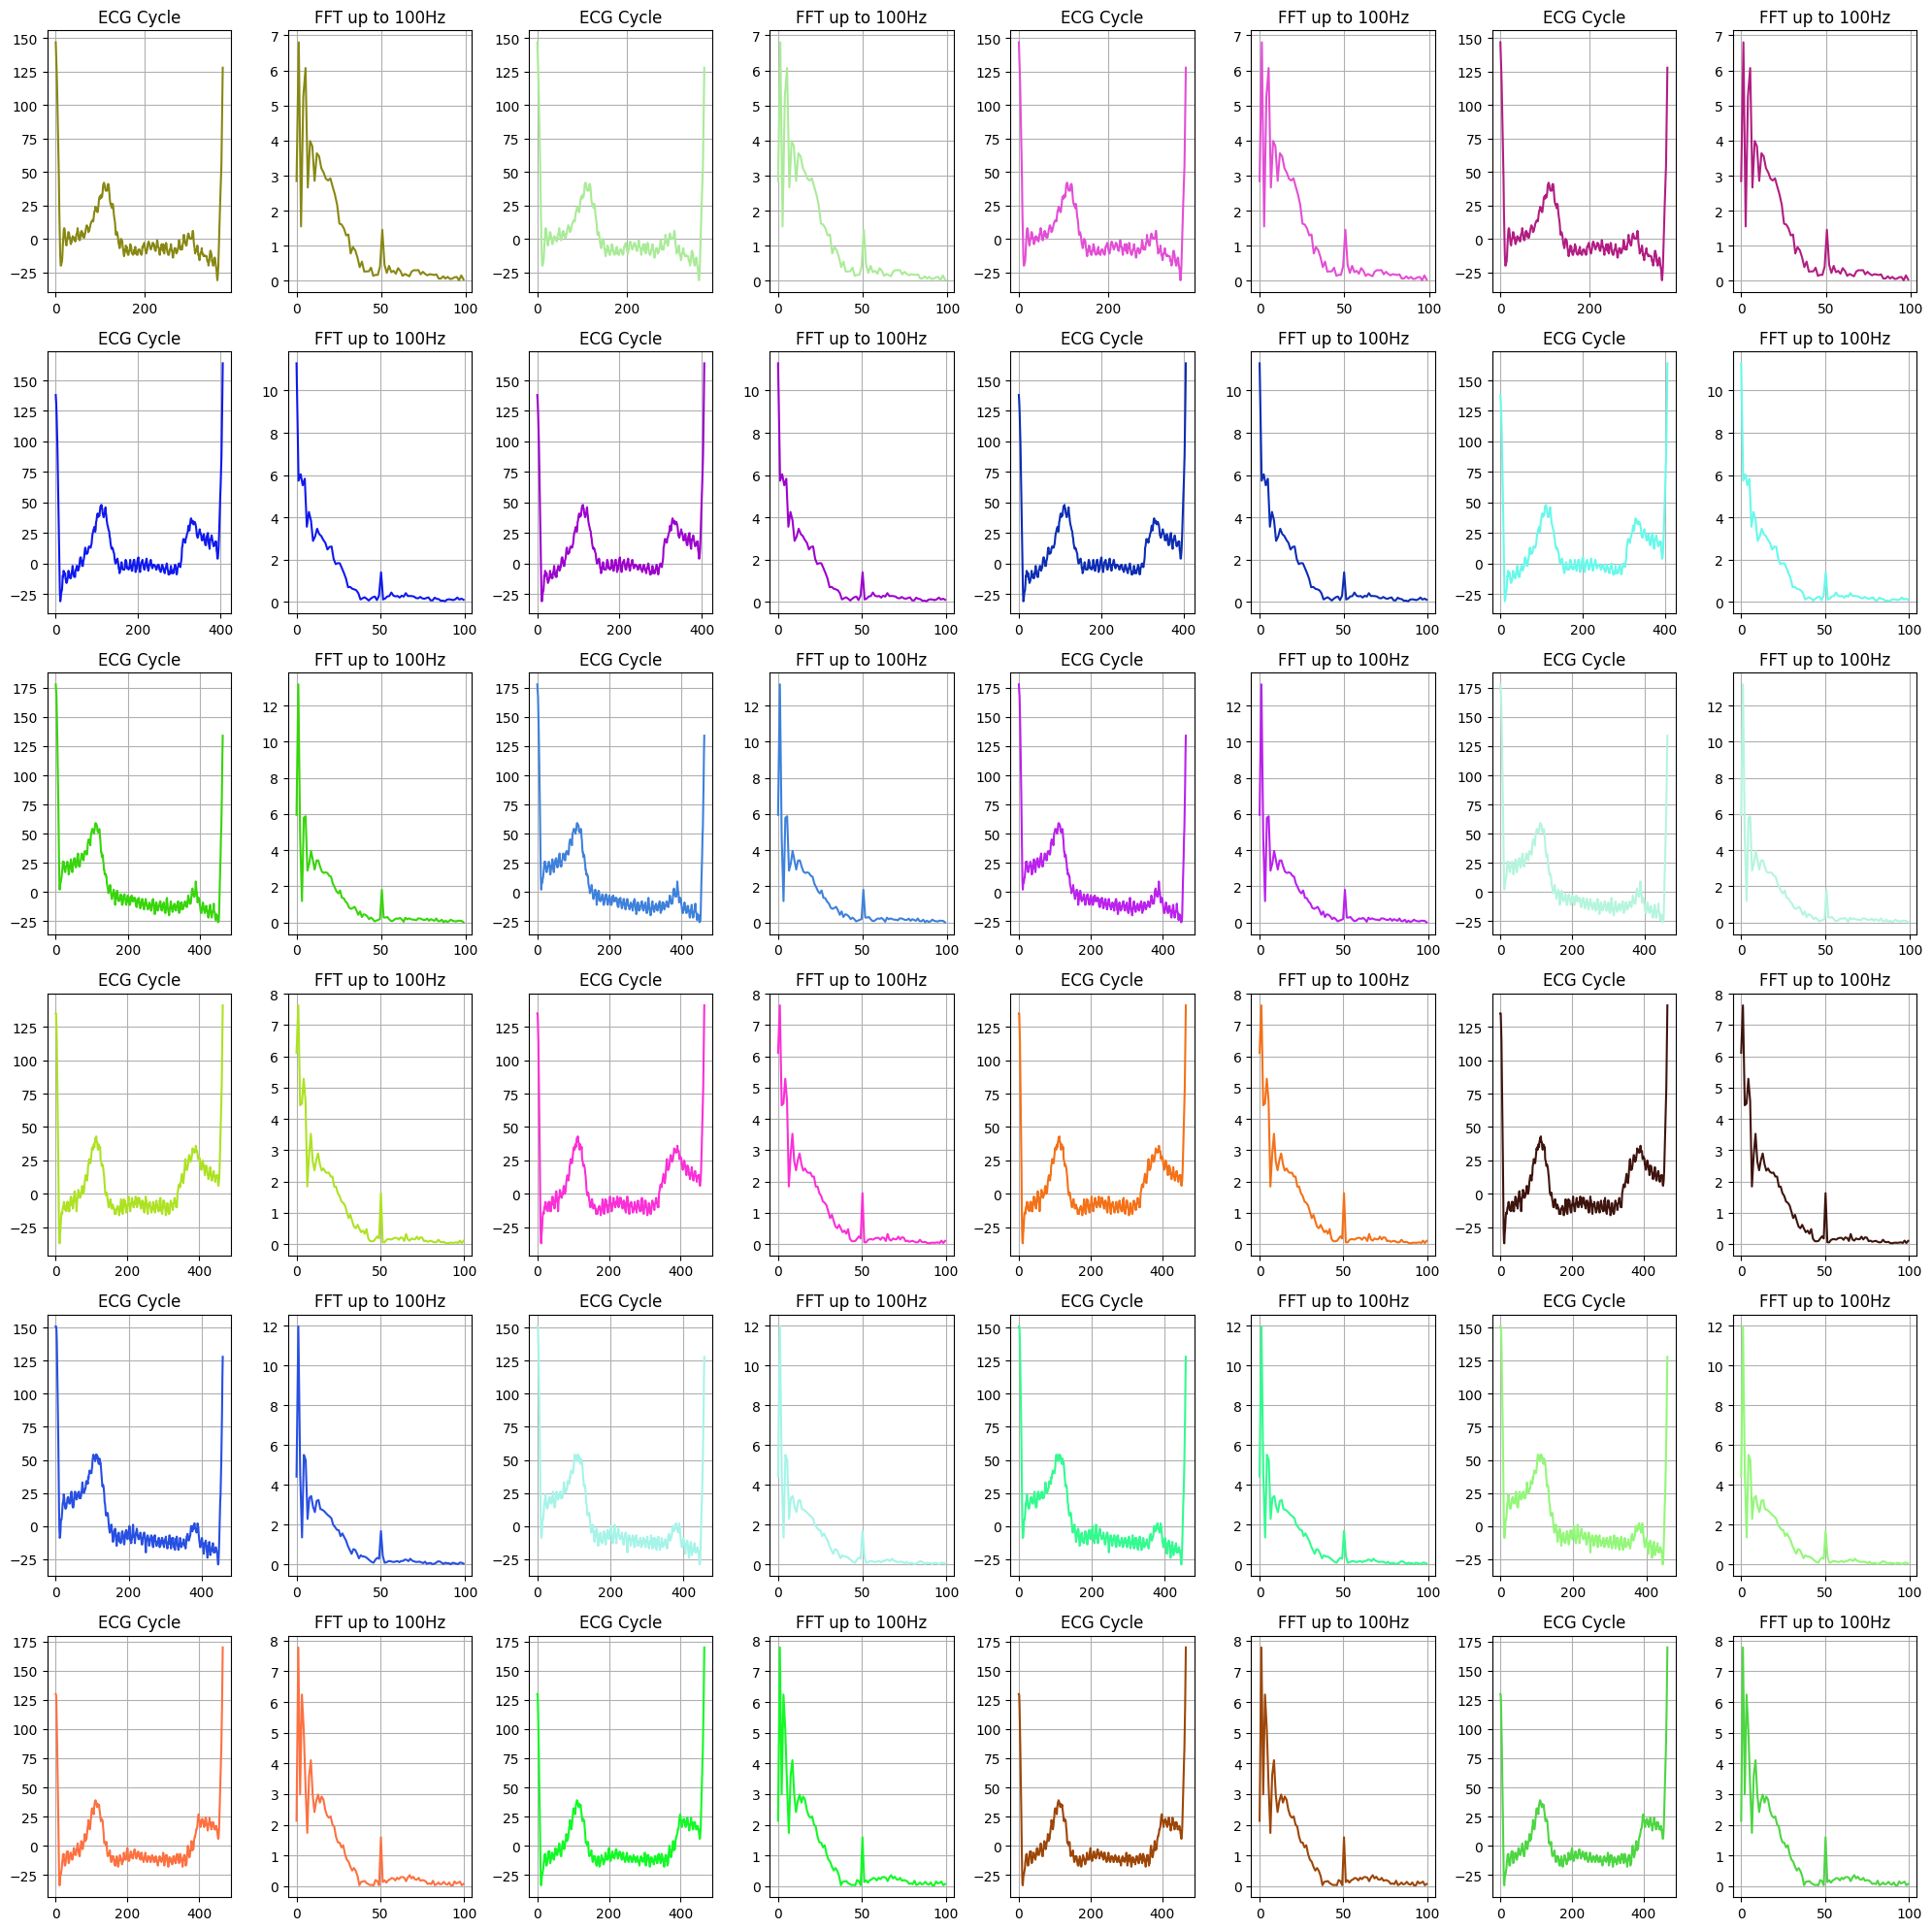

In [1]:
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# Charger le signal
def load_signals(filename):
    data = np.fromfile(filename, dtype=np.int16)
    raw_signal = data[::2]
    filtered_signal = data[1::2]
    return raw_signal, filtered_signal

def extract_cycles(signal):
    # Détecter les pics R. Vous pourriez avoir besoin d'ajuster la distance et la hauteur selon la qualité de votre signal.
    peaks, _ = find_peaks(signal, distance=50, height=70)
    
    # Découper le signal en cycles
    cycles = [signal[peaks[i]:peaks[i+1]] for i in range(len(peaks)-1)]
    
    return cycles, peaks

# Charger le signal brut
raw_signal, _ = load_signals('rec_1.dat')
cycles, peaks = extract_cycles(raw_signal)

# Afficher le signal et les pics R détectés
plt.plot(raw_signal, label='Signal')
plt.plot(peaks, raw_signal[peaks], "xr", label='Pics R')
plt.legend()
plt.show()

import random
def random_color():
    return (random.random(), random.random(), random.random())

def plot_cycle_and_fft(ax1, ax2, cycle, sampling_rate=500):
    color1 =  random_color()

    ax1.plot(cycle, color=color1)
    ax1.set_title('ECG Cycle')


    # FFT
    N = len(cycle)
    fft_vals = np.fft.fft(cycle)
    magnitude = np.abs(fft_vals) / N
    freqs = np.fft.fftfreq(N, 1 / sampling_rate)
    idx = np.where(freqs >= 100)[0][0]
    ax2.plot(freqs[:idx], magnitude[:idx],color=color1)
    ax2.set_title('FFT up to 100Hz')
    
    # Aesthetics
    ax2.grid(True)
    ax1.grid(True)

# Plotting
fig, axes = plt.subplots(nrows=6, ncols=8, figsize=(20, 20))
for i, cycle in enumerate(cycles):
    if i >= 6:  # to ensure we only plot 25 cycles and their FFTs
        break
    for j in range(4):
        plot_cycle_and_fft(axes[i, 2*j], axes[i, 2*j+1], cycle)
    

plt.tight_layout()
plt.show()

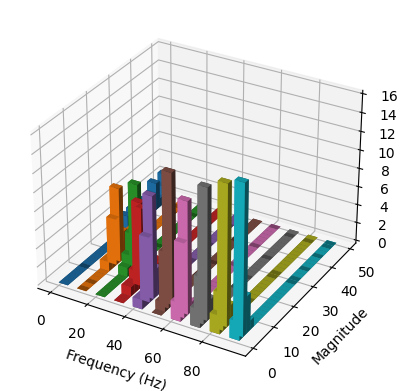

In [8]:
def load_signals(filename):
    data = np.fromfile(filename, dtype=np.int16)
    raw_signal = data[::2]
    return raw_signal

def extract_cycles(signal):
    peaks, _ = find_peaks(signal, distance=100, height=70)
    cycles = [signal[peaks[i]:peaks[i+1]] for i in range(len(peaks)-1)]
    return cycles


def compute_fft(cycle, max_len, sampling_rate=500):
    cycle_padded = np.pad(cycle, (0, max_len - len(cycle)), 'constant')
    N = len(cycle_padded)
    fft_vals = np.fft.fft(cycle_padded)
    magnitude = np.abs(fft_vals) / N
    freqs = np.fft.fftfreq(N, 1 / sampling_rate)
    idx = np.where(freqs >= 100)[0][0]
    return freqs[:idx], magnitude[:idx]

# Extract cycles
raw_signal = load_signals('rec_1.dat')
cycles = extract_cycles(raw_signal)

# Compute the maximum cycle length
max_cycle_len = max([len(cycle) for cycle in cycles])

# Compute FFTs and gather magnitudes for each frequency
magnitudes_for_freqs = []

for cycle in cycles:
    if len(magnitudes_for_freqs) == 0:  # First iteration
        freqs, magnitudes = compute_fft(cycle, max_cycle_len)
        magnitudes_for_freqs = [[] for _ in magnitudes]
    
    _, magnitudes = compute_fft(cycle, max_cycle_len)
    for i, magnitude in enumerate(magnitudes):
        magnitudes_for_freqs[i].append(magnitude)


def bin_frequencies(freqs, magnitudes):
    bins = np.arange(0, 101, 10)  # bins: 0-10Hz, 10-20Hz, ..., 90-100Hz
    binned_magnitudes = []

    for i in range(len(bins) - 1):
        start_freq = bins[i]
        end_freq = bins[i+1]
        indices = np.where((freqs >= start_freq) & (freqs < end_freq))[0]
        summed_magnitude = np.sum([magnitudes_for_freqs[j] for j in indices], axis=0)
        binned_magnitudes.append(summed_magnitude)

    return bins[:-1], binned_magnitudes

# Bin the frequencies
binned_freqs, binned_magnitudes = bin_frequencies(freqs, magnitudes_for_freqs)

# Create a 3D histogram
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define bin edges for amplitudes
magnitude_bins = np.linspace(0, max([max(mags) for mags in binned_magnitudes]), 30)

# Create 3D histogram
for idx, freq_bin in enumerate(binned_freqs):
    hist, _ = np.histogram(binned_magnitudes[idx], bins=magnitude_bins)
    x = [freq_bin] * len(hist)
    y = magnitude_bins[:-1]
    z = np.zeros_like(hist)
    dx = 5  # Width of bars
    dy = magnitude_bins[1] - magnitude_bins[0]
    dz = hist
    ax.bar3d(x, y, z, dx, dy, dz, shade=True)

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Magnitude')
ax.set_zlabel('Count')
plt.show()

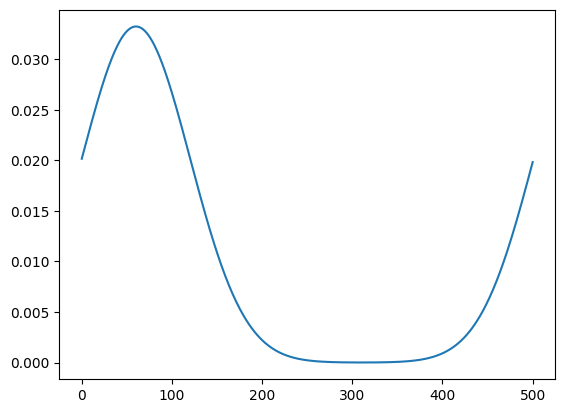

In [9]:
import numpy as np
from scipy.stats import norm
import math as m
import time
def create_gaussian(number_points,mu,sigma,coeff):
    """prend un interval et crée dessus une gaussine avec des EV mu et sd sigma
    l'intervale doit contenir 6 sigma en total . 
    On fait de sorte que la normal sur notre interval contient 99% de la masse du loi (son integrale)"""
    t = np.linspace(mu - number_points, mu + number_points, number_points * 2 + 1) # le six c'est pour les six sigma
    
    t_main = t[m.trunc(number_points-mu):number_points+int(m.trunc(number_points-mu))]
    
    t_off = np.concatenate((t[number_points+int(m.trunc(number_points-mu)):2*number_points],t[0:int(m.trunc(number_points-mu))]))


    y = (norm.pdf(t_main, mu, sigma)+norm.pdf(t_off, mu, sigma))*coeff

    
    return y



number_points = 500
plt.plot(np.linspace(0,number_points,number_points),create_gaussian(number_points,60,60,5))
plt.show()

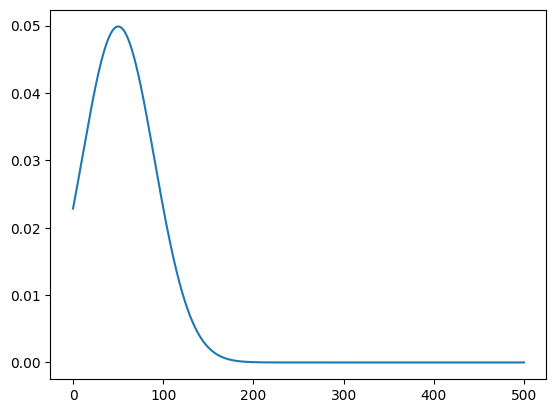

In [10]:
import numpy as np
from scipy.stats import norm

def create_gaussian(number_points,mu,sigma,coeff):
    """prend un interval et crée dessus une gaussine avec des EV mu et sd sigma
    l'intervale doit contenir 6 sigma en total . 
    On fait de sorte que la normal sur notre interval contient 99% de la masse du loi (son integrale)"""
    t = np.linspace(0 , number_points-1, number_points ) # le six c'est pour les six sigma
    return norm.pdf(t, mu, sigma)*coeff



number_points = 500
plt.plot(np.linspace(0,number_points,number_points),create_gaussian(number_points,50,40,5))
plt.show()

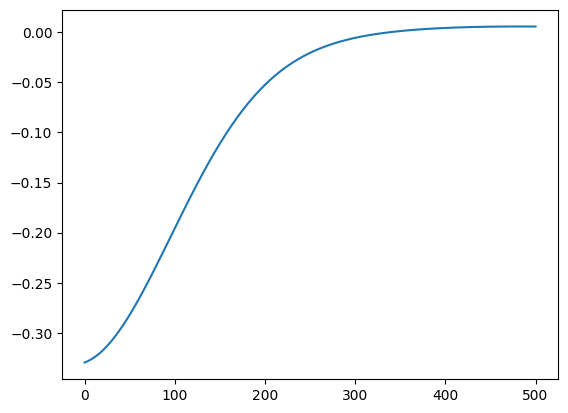

In [11]:
def create_base_signal(param,number_points):
    res= np.zeros(number_points)
    for i in param:
        res += create_gaussian(number_points,i[0],i[1],i[2])
    return res

p = [
    (-9.890703, 103.240880, -73.955464),
    (41.324024, 108.459628, -0.377841),
    (140.171365, 177.931899, 4.058402),
    (-7.734061, 239.846104, -81.172757),
    (21.968527, 276.075281, 58.605386)
]

plt.plot(np.linspace(0,number_points,number_points),create_base_signal(p,number_points))
plt.show()

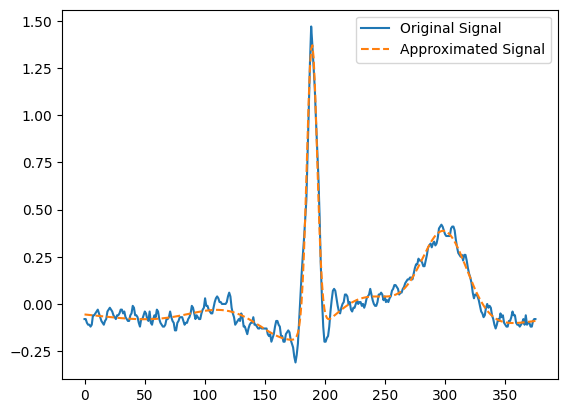

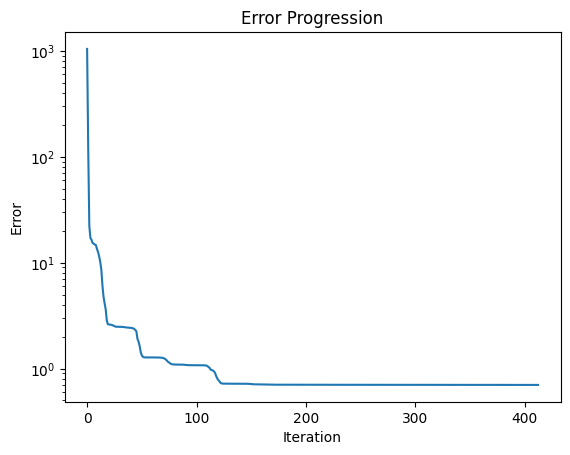

413


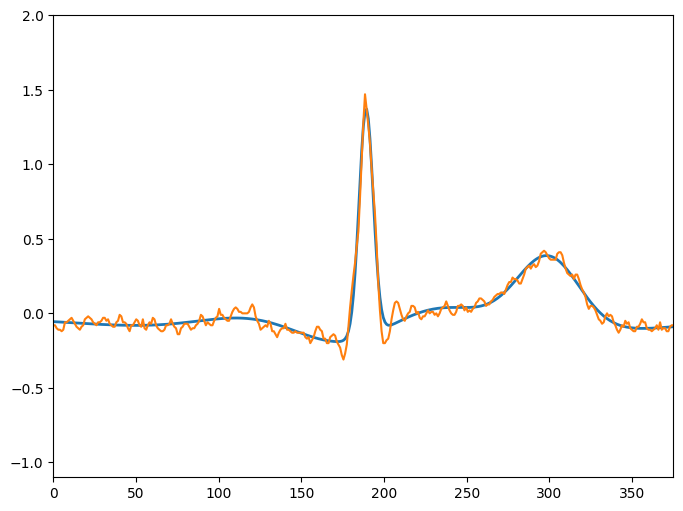

In [14]:
%matplotlib inline
from scipy.optimize import minimize
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
error_progression = []
# Define the Gaussian function
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Define the combined model with 5 Gaussian functions
def combined_gaussian(x, *params):
    return sum([gaussian(x, *params[i:i+3]) for i in range(0, len(params), 3)])

def error_function(params, x_data, y_data):
    return np.sum((combined_gaussian(x_data, *params) - y_data) ** 2)

ecg = cycles[0]
test = np.concatenate((ecg[len(ecg)//2:len(ecg+1)],ecg[0:len(ecg)//2] ))
test = np.array(test)/100
params_progression = []
# Your original signal data
x_data = np.linspace(0, len(test),len(test) )  # This is just an example. Replace with your x data.
y_data = test
def callback(params):
    params_progression.append(params.copy())
    error = error_function(params, x_data, y_data)
    error_progression.append(error)
# Provide an initial guess. Here I'm assuming 5 Gaussians with random means between 0 and 10, 
# amplitude 1, and sigma 1 for each. Adjust as necessary.
initial_guess = []
for _ in range(5):
    initial_guess.extend([5, _ *len(test)/6 + len(test)/7, 6])

# Fit the data
res = minimize(error_function, initial_guess, args=(x_data, y_data), callback=callback)

# Plot original and approximated data
plt.plot(x_data, y_data, label="Original Signal")
plt.plot(x_data, combined_gaussian(x_data, *res.x), label="Approximated Signal", linestyle="--")
plt.legend()
plt.show()

plt.figure()
plt.plot(error_progression)
plt.title("Error Progression")
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.yscale('log')
plt.show()

from matplotlib.animation import FuncAnimation, PillowWriter
import imageio
fig, ax = plt.subplots(figsize=(8,6))
x = np.linspace(0, len(test), len(test))
line1, = ax.plot(x, np.zeros_like(x), lw=2)
line2, = ax.plot(x, test)

ax.set_xlim(0, len(test))
ax.set_ylim(-1.1, 2)  # Adjust these based on your expected signal range

def init():
    line1.set_ydata(np.zeros_like(x))
    return line1,

def animate(param):
    y_data = combined_gaussian(x_data, *param)
    line1.set_ydata(y_data)
    return line1,
print(len(params_progression))
ani = FuncAnimation(fig, animate, frames=params_progression,interval=100,init_func=init, blit=True)

writer = PillowWriter(fps=120)
ani.save("teimation.gif", writer=writer)


In [13]:
def fit_gaussienne(signal,eta,param = 0 ):
    number_points=len(signal)
    succesion =[]
    param=[[number_points*i/5,20,6] for i in range(5)]
    for i in range(1000):
        grad = calc_grad(param.copy(),signal)
        for i in range(5):
            param[i] = list(np.array(param[i]) -np.array([grad[i][j]*eta for j in range(3)]))
        succesion.append([[i[0],i[1],i[2]] for i in param])  
    return param , succesion

def calc_grad(param,signal):
    grad = [[0,0,0] for i in range(5)]
    ori =  np.linalg.norm(signal-create_base_signal(param,len(signal)))
    for i1 in range(5):
        for j in range(3):
            new_param= [[i[0],i[1],i[2]] for i in param]
            new_param[i1][j] = new_param[i1][j] + 0.1
            #print(np.linalg.norm(signal-create_base_signal(new_param,len(signal))),np.linalg.norm(signal-create_base_signal(param,len(signal))))
            grad[i1][j] = (np.linalg.norm(signal-create_base_signal(new_param,len(signal))) - ori)
    return  grad

test = np.concatenate((cycles[0][len(cycles[0])//2:len(cycles[0]+1)],cycles[0][0:len(cycles[0])//2] ))
test = np.array(test)/100


res,evo = fit_gaussienne(test,40,param = 0 )
#plt.plot(np.linspace(0,len(test),len(test)),create_base_signal(fit_gaussienne(test,20,param = 0 ),len(test)))
#plt.plot((np.linspace(0,len(test),len(test))),test)
#plt.show()

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


res,evo = fit_gaussienne(test,50,param = 0 )
#plt.plot(np.linspace(0,len(test),len(test)),create_base_signal(fit_gaussienne(test,20,param = 0 ),len(test)))
#plt.plot((np.linspace(0,len(test),len(test))),test)
#plt.show()
print("on")
from matplotlib.animation import FuncAnimation, PillowWriter
import imageio

frames = []
for param in evo:
    fig, ax = plt.subplots()
    
    # Plot your data here
    ax.plot(np.linspace(0,len(test),len(test)),create_base_signal(param,len(test))) # replace this with your plotting logic
    ax.plot(np.linspace(0,len(test),len(test)),test)
    fig.canvas.draw()   
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    frames.append(image)
    plt.close(fig)
    
imageio.mimsave('teimation.gif', frames, 'GIF', duration=0.1)

on


KeyboardInterrupt: 

on


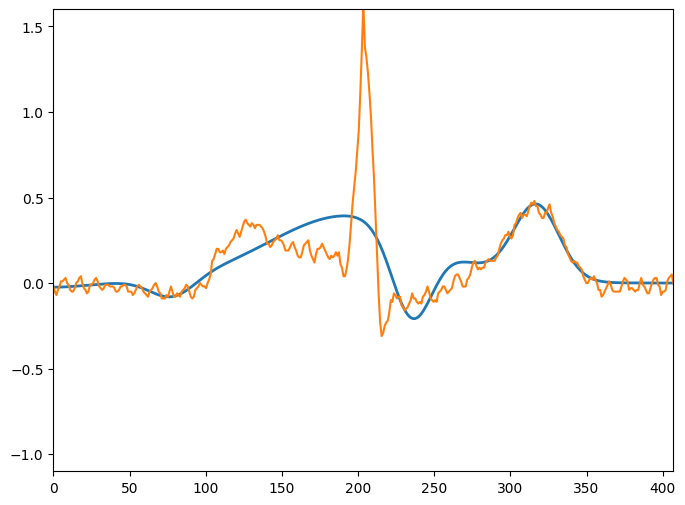

In [ ]:
def fit_gaussienne(signal,eta,param = 0 ):
    number_points=len(signal)
    succesion =[]
    param=[[number_points*i/5,20,6] for i in range(5)]
    for i1 in eta:
        grad = calc_grad(param.copy(),signal)
        for i in range(5):
            param[i] = list(np.array(param[i]) -np.array([grad[i][j]*i1 for j in range(3)]))
        succesion.append([[k[0],k[1],k[2]] for k in param])  
    return param , succesion

def calc_grad(param,signal):
    grad = [[0,0,0] for i in range(5)]
    ori =  np.linalg.norm(signal-create_base_signal(param,len(signal)))
    for i1 in range(5):
        for j in range(3):
            new_param= [[i[0],i[1],i[2]] for i in param]
            new_param[i1][j] = new_param[i1][j] + 0.1
            #print(np.linalg.norm(signal-create_base_signal(new_param,len(signal))),np.linalg.norm(signal-create_base_signal(param,len(signal))))
            grad[i1][j] = (np.linalg.norm(signal-create_base_signal(new_param,len(signal))) - ori)
    return  grad

test = np.concatenate((cycles[1][len(cycles[1])//2:len(cycles[1]+1)],cycles[1][0:len(cycles[1])//2] ))
test = np.array(test)/100

eta=[200 for i in range (1000)] 
res,evo = fit_gaussienne(test,eta,param = 0 )
#plt.plot(np.linspace(0,len(test),len(test)),create_base_signal(fit_gaussienne(test,20,param = 0 ),len(test)))
#plt.plot((np.linspace(0,len(test),len(test))),test)
#plt.show()

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
#plt.plot(np.linspace(0,len(test),len(test)),create_base_signal(fit_gaussienne(test,20,param = 0 ),len(test)))
#plt.plot((np.linspace(0,len(test),len(test))),test)
#plt.show()
print("on")
from matplotlib.animation import FuncAnimation, PillowWriter
import imageio
fig, ax = plt.subplots(figsize=(8,6))
x = np.linspace(0, len(test), len(test))
line1, = ax.plot(x, np.zeros_like(x), lw=2)
line2, = ax.plot(x, test)

ax.set_xlim(0, len(test))
ax.set_ylim(-1.1, 1.6)  # Adjust these based on your expected signal range

def init():
    line1.set_ydata(np.zeros_like(x))
    return line1,

def animate(param):
    y_data = create_base_signal(param, len(test))
    line1.set_ydata(y_data)
    return line1,

ani = FuncAnimation(fig, animate, frames=evo, init_func=init, blit=True)

writer = PillowWriter(fps=10)
ani.save("teimation.gif", writer=writer)
